In [1]:
import hoomd
import hoomd.md
from matplotlib import pyplot
%matplotlib inline

HOOMD-blue v2.1.3 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX 
Compiled: 02/07/2017
Copyright 2009-2016 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----


# Tuning neighbor list parameters

There are a number of parameters to the neighbor list that influence the performance of the simulation but not the correctness. The buffer radius ``r_buff`` controls how many extra neighbors are included in the list. The larger ``r_buff``, the less off the list is rebuilt, but the more extra force computations are necessary. When ``r_buff`` is small, the nlist is built more often, but there are fewer extra forces. These two competing effects yield an optimal value for ``r_buff``. You cannot predict the optimal performing ``r_buff``, you need to benchmark it as it depends strongly on your model, parameters, and hardware.

Here is a simple 3D lj fluid model to demonstrate nlist tuning.

In [2]:
hoomd.context.initialize('')
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.05), n=10)
nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
hoomd.md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.langevin(group=hoomd.group.all(), kT=1.0, seed=2)

notice(2): This system is not compute exclusive, using local rank to select GPUs
notice(2): Unable to identify node local rank information
notice(2): Using global rank to select GPUs
HOOMD-blue is running on the following GPU(s):
 [0]            Tesla K20c  13 SM_3.5 @ 0.706 GHz, 5060 MiB DRAM
notice(2): Group "all" created containing 1000 particles
notice(2): integrate.langevin/bd is using specified gamma values


## Tune r_buff

HOOMD has a builtin method to tune the optimal ``r_buff`` value.

In [3]:
nl.tune(warmup=20000, r_min=0.05, r_max=1.55, jumps=11, steps=5000, set_max_check_period=False)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:03 | Step 20000 / 20000 | TPS 6343.77 | ETA 00:00:00
Average TPS: 6341.32
---------
-- Neighborlist stats:
1854 normal updates / 68 forced updates / 0 dangerous updates
n_neigh_min: 75 / n_neigh_max: 95 / n_neigh_avg: 86.294
shortest rebuild period: 8
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 32 / n_max: 43 / n_avg: 37.037
** run complete **
** starting run **
Time 00:00:04 | Step 25000 / 25000 | TPS 4844.14 | ETA 00:00:00
Average TPS: 4838.95
---------
-- Neighborlist stats:
2525 normal updates / 18 forced updates / 0 dangerous updates
n_neigh_min: 51 / n_neigh_max: 67 / n_neigh_avg: 58.81
shortest rebuild period: 1
-- Cell list stats:
Dimension: 4, 4, 4
n_min    : 11 / n_max: 20 / n_avg: 15.625
** run complete **
** starting ru

(1.1, 24)

The resulting performance vs r_buff curve looks like this.

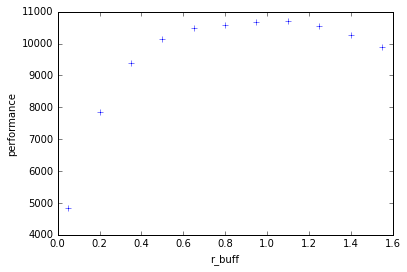

In [4]:
pyplot.plot([0.05, 0.2, 0.35, 0.49999999999999994, 0.65, 0.8, 0.95, 1.1, 1.25, 1.4, 1.55], [4829.723276175168, 7856.706248752748, 9388.825044878584, 10131.404313951958, 10472.980756945157, 10589.271796957068, 10681.843429811744, 10708.885376374485, 10561.669588728586, 10257.104583489754, 9902.029321889228], '+')
pyplot.xlabel('r_buff')
pyplot.ylabel('performance')

Tune r_buff in a few test simulations at the range of parameters you intend to explore. Then set a static r_buff in your production simulations.

In [5]:
nl.set_params(r_buff = 1.1, check_period=23)
hoomd.run(5000)

** starting run **
Time 00:00:24 | Step 210000 / 210000 | TPS 11514.8 | ETA 00:00:00
Average TPS: 11490.3
---------
-- Neighborlist stats:
133 normal updates / 17 forced updates / 0 dangerous updates
n_neigh_min: 155 / n_neigh_max: 181 / n_neigh_avg: 167.19
shortest rebuild period: 24
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 113 / n_max: 131 / n_avg: 125
** run complete **


## Use a different acceleration structure

HOOMD provides 3 types of acceleration structures for neighbor lists. The cell list (consider this the default), the stenciled cell list, and the tree data structure. This example just demonstrates how to enable the different acceleration structures. The various acceleration structures have different performance characteristics depending on the distribution of particles in the system and range of *r_cut* values in the pair potential.

### Stencil cell list

In [6]:
hoomd.context.initialize('')
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.05), n=10)
nl = hoomd.md.nlist.stencil(r_buff = 1.1, cell_width = 1.8)
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
hoomd.md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.langevin(group=hoomd.group.all(), kT=1.0, seed=2)

notice(2): Group "all" created containing 1000 particles
-----
You are using stenciled neighbor lists. Please cite the following:
* M P Howard, J A Anderson, A Nikoubashman, S C Glotzer, and A Z
  Panagiotopoulos. "Efficient neighbor list calculation for molecular simulation
  of colloidal systems using graphics processing units", Computer Physics
  Communications 203 (2016) 45--52
-----
notice(2): integrate.langevin/bd is using specified gamma values


In [7]:
hoomd.run(5000)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:01 | Step 5000 / 5000 | TPS 4066.3 | ETA 00:00:00
Average TPS: 4061.93
---------
-- Neighborlist stats:
133 normal updates / 18 forced updates / 0 dangerous updates
n_neigh_min: 157 / n_neigh_max: 181 / n_neigh_avg: 167.024
shortest rebuild period: 23
-- Cell list stats:
Dimension: 5, 5, 5
n_min    : 6 / n_max: 11 / n_avg: 8
** run complete **


To fully evaluate the performance of the stencil cell list, tune the ``cell_width`` and ``r_buff``.

### Tree

In [8]:
hoomd.context.initialize('')
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.05), n=10)
nl = hoomd.md.nlist.tree(r_buff = 1.1)
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
hoomd.md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.langevin(group=hoomd.group.all(), kT=1.0, seed=2)

notice(2): Group "all" created containing 1000 particles
-----
You are using tree neighbor lists. Please cite the following:
* M P Howard, J A Anderson, A Nikoubashman, S C Glotzer, and A Z
  Panagiotopoulos. "Efficient neighbor list calculation for molecular simulation
  of colloidal systems using graphics processing units", Computer Physics
  Communications 203 (2016) 45--52
-----
notice(2): integrate.langevin/bd is using specified gamma values


In [9]:
hoomd.run(5000)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:01 | Step 5000 / 5000 | TPS 2790.58 | ETA 00:00:00
Average TPS: 2788.83
---------
-- Neighborlist stats:
132 normal updates / 18 forced updates / 0 dangerous updates
n_neigh_min: 155 / n_neigh_max: 179 / n_neigh_avg: 166.81
shortest rebuild period: 23
** run complete **
